In [1]:
# Selective and non-selective excitation
import os
import ctypes
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Constants 
gamma       = 267522187.44; # rad/s/T
gamma_hz    = gamma/2/np.pi
FA          = 45 * np.pi/180
ntime       = 400; # number of samples
rf_len      = 4e-3; # second
td          = rf_len/ntime; # dwell-time 
voxel_sz    = np.array([3, 3, 3]) * 1e-3
fov         = np.array([[-60, 45], [-30, 60], [-90, 90]]) * 1e-3
voxel_no    = np.rint((fov[:,1]-fov[:,0]) / voxel_sz).astype(int)
rf_tbw      = 12
is_sinc     = True
is_selective= True

In [2]:
# test meshgrid
prx, pry, prz = np.meshgrid(np.linspace(-3,-2,2), np.linspace(0,1,2), np.linspace(5,6,2), indexing='ij')
print(prx.shape)
print(f'prx = {prx.flatten(order="F")}')
print(f'pry = {pry.flatten(order="F")}')
print(f'prz = {prz.flatten(order="F")}')

# positions
prx, pry, prz = np.meshgrid(np.linspace(fov[0,0],fov[0,1],voxel_no[0],dtype=np.float32), np.linspace(fov[1,0],fov[1,1],voxel_no[1],dtype=np.float32), np.linspace(fov[2,0],fov[2,1],voxel_no[2],dtype=np.float32), indexing='ij')  
sz      = prz.shape
pr      = np.vstack((prx.flatten(order='F'), pry.flatten(order='F'), prz.flatten(order='F'))).copy(order='F')
npos    = pr.shape[1] # number of spatial positions

print(sz)
print(pr.shape)
print(pr.flags)

(2, 2, 2)
prx = [-3. -2. -3. -2. -3. -2. -3. -2.]
pry = [0. 0. 1. 1. 0. 0. 1. 1.]
prz = [5. 5. 5. 5. 6. 6. 6. 6.]
(35, 30, 60)
(3, 63000)
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [3]:
# off-resonance
b0 = np.zeros(prx.shape, dtype=np.float32, order='F')
m0 = np.zeros((3,)+ prx.shape, dtype=np.float32, order='F')
m0[-1,...] = 1
img = nib.Nifti1Image(np.moveaxis(m0, 0, -1), affine=np.eye(4))
nib.save(img, 'm0.nii')
print(b0.shape)
print(m0.shape)

(35, 30, 60)
(3, 35, 30, 60)


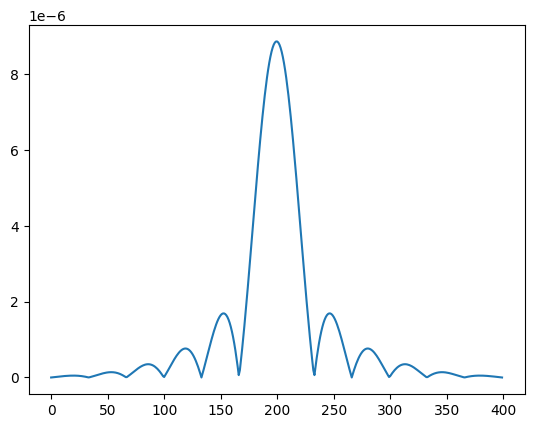

In [4]:
# sinc pulse
b1 = np.ones((ntime, 1), dtype=np.complex64, order='F') * FA/gamma/rf_len; # this is for non-selective
if is_sinc == True :
    t = np.linspace(-rf_len/2, rf_len/2, ntime) # must be column
    BW = rf_tbw/rf_len
    # didn't use 2pi -> we are interested in full BW not only the positive
    snc = np.sinc(t * BW) 
    hamming_window = 0.53836 + 0.46164*np.cos(2*np.pi * np.linspace(-0.5,0.5,ntime))
    rf = snc * hamming_window
    rf = rf / np.sum(rf)# normalize
    b1 = (rf * FA/gamma/td).astype(np.complex64)

# adding RF phase
# b1.imag = b1.real
# b1 = b1 / np.sqrt(2)

plt.plot(np.abs(b1))
plt.show()

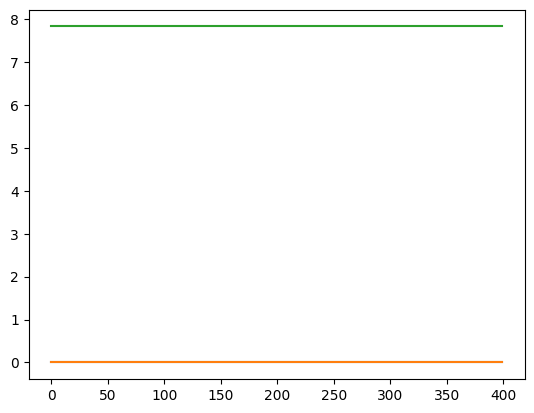

In [5]:
# gradients
gr = np.zeros((3, ntime), dtype=np.float32, order='F')
if is_selective:
    BW = rf_tbw/rf_len; # [Hz]
    gr[2,:] = BW / (3*voxel_sz[2]) / gamma_hz

plt.plot(gr[0] * 1e3) # mT/m
plt.plot(gr[1] * 1e3)
plt.plot(gr[2] * 1e3)
plt.show()

In [6]:
# RUN
result   = np.zeros_like(m0, dtype=np.float32, order='F')
#dir_path = os.path.dirname(os.path.realpath(__file__))
libbloch_path = "/home/ali/Nextcloud/MATLAB/shimming/B1GUI/bloch_simulator/lib/libbloch.so" # os.path.join(dir_path, "..", "lib", "libbloch.so")
#libbloch_path = "/home/ali/Nextcloud/Python/recoMRD/recoMRD/lib/libbet2.so" # os.path.join(dir_path, "..", "lib", "libbloch.so")

print(f'Library: {libbloch_path}')
handle   = ctypes.CDLL(libbloch_path) 

handle.bloch_sim.argtypes = [np.ctypeslib.ndpointer(np.complex64, ndim=b1.ndim, flags='F'),
                             np.ctypeslib.ndpointer(np.float32, ndim=gr.ndim, flags='F'),
                             ctypes.c_float,
                             np.ctypeslib.ndpointer(np.float32, ndim=b0.ndim, flags='F'),
                             np.ctypeslib.ndpointer(np.float32, ndim=pr.ndim, flags='F'),
                             ctypes.c_float,
                             ctypes.c_float,
                             np.ctypeslib.ndpointer(np.float32, ndim=m0.ndim, flags='F'),
                             ctypes.c_int32,
                             ctypes.c_int32,
                             np.ctypeslib.ndpointer(np.float32, ndim=result.ndim, flags='F'),
                             ctypes.c_bool]

handle.bloch_sim(b1, gr, td, b0, pr, 1000., 1000., m0, b0.size, ntime, result, False)
result = np.moveaxis(result, 0, -1)


Library: /home/ali/Nextcloud/MATLAB/shimming/B1GUI/bloch_simulator/lib/libbloch.so
pB1=(-2.64631e-23,0) (-3.4174e-09,0) (-6.85407e-09,0) (-1.02947e-08,0)
pGr=0 0 0.00782887
0 0 0.00782887
0 0 0.00782887
0 0 0.00782887

pB0=0 0 0 0
pGr=0 0 1
0 0 1
0 0 1
0 0 1

td=1e-05 T1&T2=1000 1000 nPosition=63000 nTime=400 saveAll=0


In [7]:
print(result.shape)
print(np.abs(result[...,0]).max())
print(np.abs(result[...,1]).max())
print(np.min(result[...,2]))

img = nib.Nifti1Image(result, affine=np.eye(4))
nib.save(img, 'result.nii')

(35, 30, 60, 3)
0.12354735
0.70027196
0.7082711
